## import libraries 

In [1]:
import pandas
import configparser
import psycopg2

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

host = config['myaws']['host']
db = config['myaws']['db']
user = config['myaws']['user']
pwd = config['myaws']['pwd']

In [3]:
conn = psycopg2.connect(host = host,
                       user = user,
                        password = pwd,
                        dbname = db
                       )
cur = conn.cursor()

## create the hosue table

make sure change the schema name to your gp number

In [4]:


# replace the schema and table name to your schema and table name
table_sql = """
            CREATE TABLE IF NOT EXISTS gp1.house
            (

                price integer,
                bed integer,
                bath integer,
                area integer,
                address VARCHAR(200),
                PRIMARY KEY(address)
            );

            """



use the bellow cell only if you want to delete the table

In [117]:
#conn.rollback()
#table_sql="drop table if exists demo.house"

In [5]:

cur.execute(table_sql)
conn.commit()

## define the search region

In [6]:
url = 'https://www.trulia.com/VA/Warrenton/20186/'

In [7]:


import urllib.request
response = urllib.request.urlopen(url)
html_data= response.read()
print(html_data.decode('utf-8'))



<!DOCTYPE html><html lang="en"><head><meta charSet="utf-8"/><script>
            window.__uspapi = function(command, version, callback) {
              try {
                if (command === 'getUSPData') {
                  var cookies = document.cookie.split(';');
                  for (var i = 0; i < cookies.length; i++) {
                    var cookie = cookies[i];
                    var separatorIndex = cookie.indexOf('=');
                    separatorIndex = separatorIndex < 0 ? cookie.length : separatorIndex;
                    var cookie_name = decodeURIComponent(cookie.slice(0, separatorIndex).replace(/^\s+/, ''));
                    if (cookie_name === 'usprivacy') {
                      var uspString = decodeURIComponent(cookie.slice(separatorIndex + 1));
                      callback({ version: version, uspString: uspString }, true);
                      return;
                    }
                  }
                }
              } catch (ex) {
                c

In [9]:


from bs4 import BeautifulSoup
soup = BeautifulSoup(html_data,'html.parser')
print (soup)



<!DOCTYPE html>
<html lang="en"><head><meta charset="utf-8"/><script>
            window.__uspapi = function(command, version, callback) {
              try {
                if (command === 'getUSPData') {
                  var cookies = document.cookie.split(';');
                  for (var i = 0; i < cookies.length; i++) {
                    var cookie = cookies[i];
                    var separatorIndex = cookie.indexOf('=');
                    separatorIndex = separatorIndex < 0 ? cookie.length : separatorIndex;
                    var cookie_name = decodeURIComponent(cookie.slice(0, separatorIndex).replace(/^\s+/, ''));
                    if (cookie_name === 'usprivacy') {
                      var uspString = decodeURIComponent(cookie.slice(separatorIndex + 1));
                      callback({ version: version, uspString: uspString }, true);
                      return;
                    }
                  }
                }
              } catch (ex) {
                

## insert the records into database

In [10]:

for li_class in soup.find_all('li', class_ = 'Grid__CellBox-sc-144isrp-0 SearchResultsList__WideCell-b7y9ki-2 jiZmPM'):
    try:
        for price_div in li_class.find_all('div',{'data-testid':'property-price'}):
            price =int(price_div.text.replace('$','').replace(",",""))
        for bed_div in li_class.find_all('div', {'data-testid':'property-beds'}):
            bed= int(bed_div.text.replace('bd','').replace(",",""))
        for bath_div in li_class.find_all('div',{'data-testid':'property-baths'}):
            bath =int(bath_div.text.replace('ba','').replace(",",""))
        for area_div in li_class.find_all('div',{'data-testid':'property-floorSpace'}):
            area=int(area_div.text.split('sqft')[0].replace(",",""))
        for address_div in li_class.find_all('div',{'data-testid':'property-address'}):
            address =address_div.text

        try:
            sql_insert = """
                        insert into gp1.house(price,bed,bath,area,address)
                        values('{}','{}','{}','{}','{}')            
                        """.format(price,bed,bath,area,address)

            cur.execute(sql_insert)
            conn.commit()
        except:
            conn.rollback()
    except:
        pass
        

## Query the Table

In [11]:
df = pandas.read_sql_query('select * from gp1.house ', conn)
df[:10]

price  bed  bath   area                                        address
0  29950000   22    15  38500          7500 Ironwood Ln, Warrenton, VA 20186
1    489500    4     3   2005          54 Winchester St, Warrenton, VA 20186
2  14200000    9    11  14500           6580 Timothy Ln, Warrenton, VA 20186
3   1500000    7     6   6015  8079 Cannonball Ridge Ln, Warrenton, VA 20186
4    365000    7     6   6015                   Lock Ln, Warrenton, VA 20186
5    440000    3     2   1570        8232 Lees Ridge Rd, Warrenton, VA 20186
6    375000    3     3   1520               87 Haiti St, Warrenton, VA 20186
7    310000    3     4   1602          186 Fairfield Dr, Warrenton, VA 20186
8    997500    6     6   4658         7352 Huntsmans Dr, Warrenton, VA 20186
9    570000    6     4   3944         242 Breezewood Dr, Warrenton, VA 20186

## basic stat

In [12]:
df.describe()

price        bed       bath          area
count  5.900000e+01  59.000000  59.000000     59.000000
mean   1.427401e+06   4.220339   3.372881   3324.576271
std    4.221939e+06   2.748465   2.156772   5071.708405
min    1.400000e+05   2.000000   1.000000    960.000000
25%    3.425000e+05   3.000000   2.000000   1665.000000
50%    5.250000e+05   4.000000   3.000000   2184.000000
75%    7.707500e+05   4.500000   4.000000   3276.000000
max    2.995000e+07  22.000000  15.000000  38500.000000

## price distribution

<AxesSubplot:>

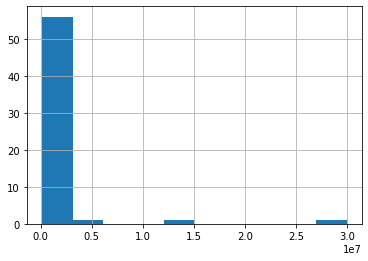

In [13]:
df['price'].hist()

## bed vs bath

<AxesSubplot:xlabel='bed', ylabel='bath'>

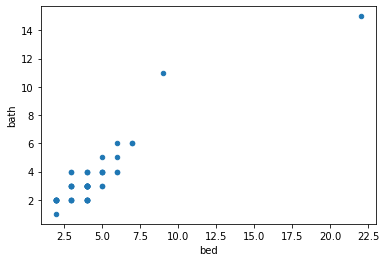

In [14]:
df.plot.scatter(x='bed',y='bath')